## Deploy a generic flist

#### Requirements

In order to be able to deploy this example deployment you will have to have the following components activated
- the Jumpscale SDK, in the form of a local container with the SDK, or a grid based SDK container.  Getting started instuctions are [here](https://github.com/threefoldfoundation/info_projectX/tree/development/doc/jumpscale_SDK) 
- if you use a locally installed container with the 3bot SDK you need to have the wireguard software installed.  Instructions to how to get his installed on your platform can be found [here](https://www.wireguard.com/install/)
- capacity reservation are not free so you will need to have some ThreeFold Tokens (TFT) to play around with.  Instructions to get tokens can be found [here](https://github.com/threefoldfoundation/info_projectX/blob/development/doc/jumpscale_SDK_information/payment/FreeTFT_testtoken.md)

After following these install instructions you should end up having a local, working jumpscale SDK installed.  You can work / connect to the installed SDK as described [here](https://github.com/threefoldfoundation/info_projectX/blob/development/doc/jumpscale_SDK/SDK_getting_started.md)

### Overview
The design a simple kubernetes cluster we need to follow a few steps:
- create (or identify and use) an overlay network that spans all of the nodes needed in the solution
- identify which nodes are involved in the kubernetes cluster, master and worker nodes
- create reservations for the kubernetes virtual machines.
- deploy the kubernetes cluster.

#### Create overlay network of identity an previously deployed overlay network

Each overlay network is private and contains private IP addresses.  Each overlay network is deployed in such a way that is has no connection to the public (IPv4 or IPv6) network directly.  In order to work with such a network a tunnel needs to be created between the overlay network on the grid and your local network.  You can find instructions how to do that [here](https://github.com/threefoldfoundation/info_projectX/blob/development/doc/jumpscale_SDK_examples/network/overlay_network.md)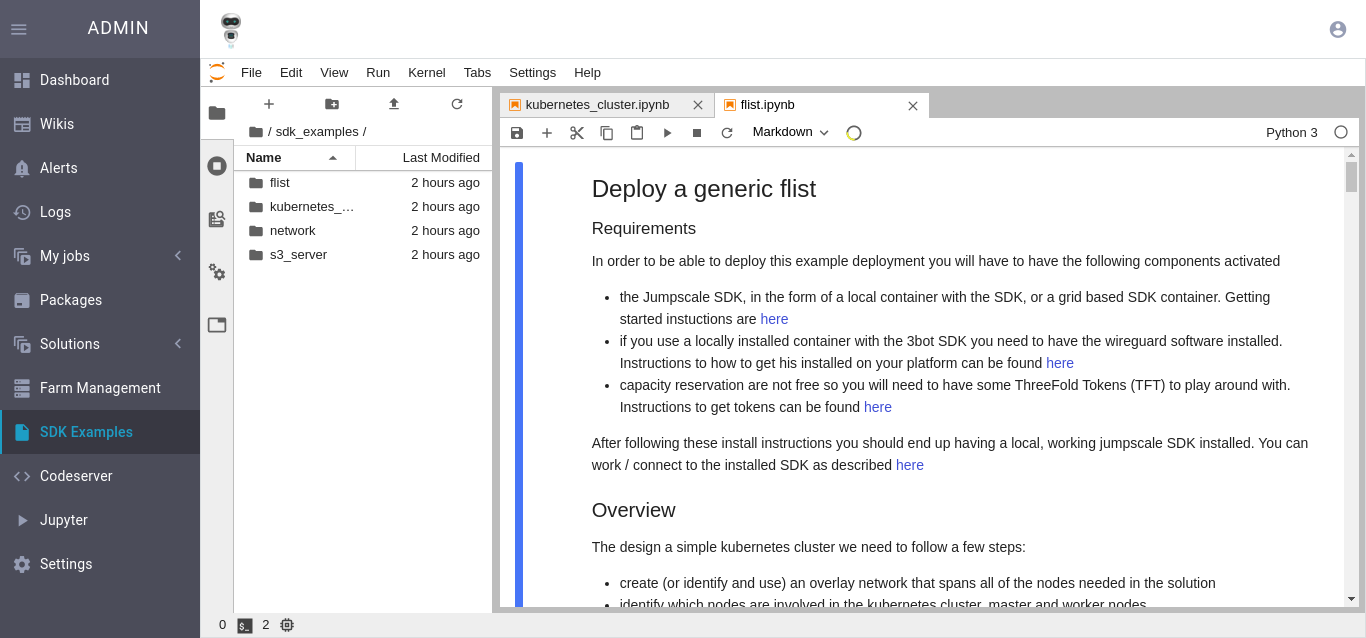

#### Set up the capacity environment to find, reserve and configure

Make sure that your SDK points to the mainnet explorer for deploying this capacity example.  Also make sure you have an identity loaded.  The example code uses the default identity.  Multiple identities can be stored in the jumpscale SDK.  To check your available identities you can request the number of identities available for you by typing `j.myidentities` in the kosmos shell.


In [ ]:
j.clients.explorer.default_addr_set('explorer.grid.tf')

# Which identities are available in you SDK
j.myidentities

# Make sure I have an identity (set default one for mainnet of testnet)
me = j.myidentities.default

# Load the zero-os sal and reate empty reservation method
zos = j.sal.zosv2
r = zos.reservation_create()

#### Set up the capacity environment to find, reserve and configure

Make sure that your SDK points to the mainnet explorer for deploying this capacity example.  Also make sure you have an identity loaded.  The example code uses the default identity.  Multiple identities can be stored in the jumpscale SDK.  To check your available identities you can request the number of identities available for you by typing `j.myidentities` in the kosmos shell.

#### What is an flist?  

An flist is a very special container images.  One of the challenges with industry leading technologies like docker and kubernetes is that every node involved in an IT architecture has to have local copies of all of the images it needs to run as containers. These can either be base images on which specific modifications need to be made or they are specific images downloaded from the docker hub or a private image repository (enterprise use cases).  Having these images exists on many different nodes requires these to be downloaded and maintained for version control and bug fixes.  This is waistfull (many times the same image required storage space) and time consuming. 

The flist solves that issue by facilitating container images to be made available on fly to nodes that needs the content of a container image over the network from a so called hub.  There is a public hub that serves images but the hub facility is open source and can be replicated for private or corporate usage.  The hub can be found here: `http://hub.grid.tf`.





In [1]:
You have created a network in the network creation [notebook](https://github.com/threefoldfoundation/info_projectX/blob/development/code/jupyter/SDK_examples/network/overlay_network.ipynb) with the following details:
```
demo_ip_range="72.20.0.0/16"
demo_port=8030
demo_network_name="demo_network_name_01"
```:

SyntaxError: invalid syntax (<ipython-input-1-7499c11ebb42>, line 1)

In [ ]:
# create overlay network definition in datastructure called "network"
network = zos.network.create(r, ip_range="172.20.0.0/16", network_name=u_networkname)

nodes_mazraa = zos.nodes_finder.nodes_search(farm_id=123428) # (IPv6 nodes)
nodes_salzburg = zos.nodes_finder.nodes_search(farm_id=12775) # (IPv6 nodes)
nodes_vienna_1 = zos.nodes_finder.nodes_search(farm_id=82872) # (IPv6 nodes)
nodes_belgium = zos.nodes_finder.nodes_search(farm_id=1) # (IPv4 nodes, to be used as ingress/egress point.  These are not webgatewaysm, just nodes connected to the internet with IPv4 addresses)
nodes_munich = zos.nodes_finder.nodes_search(farm_id=50669) #(IPv6 nodes)

# Make a network spanning Salzburg, Vienna, Lichristu and Munich
nodes_all = nodes_salzburg[:5] + nodes_vienna_1[:5] + nodes_belgium[:5]+nodes_mazraa[:5]


# make sure to set a new port,empty 
for i, node in enumerate(nodes_all):
    if zos.nodes_finder.filter_is_up(node):
        iprange = f"172.20.{i+10}.0/24"
        zos.network.add_node(network, node.node_id , iprange, wg_port=u_port)
        print("Node: ", i, " ID: ", node.node_id, " IPv4 address: ", iprange)

# Enter here the node_id for the node that is the IPv4 bridge to create the wireguard config.
wg_config = zos.network.add_access(network, 'CBDY1Fu4CuxGpdU3zLL9QT5DGaRkxjpuJmzV6V5CBWg4', '172.20.100.0/24', ipv4=True)

print("wireguard configuration")
print(wg_config)


# Set the duration for the reservation
import time
expiration = j.data.time.epoch + (10*60)
#expiration = j.data.time.epoch + (5*60)

# register the reservation
rid = zos.reservation_register(r, expiration, identity=me)
time.sleep(5)

# inspect the result of the reservation provisioning
result = zos.reservation_result(rid)
print("provisioning result")
print(result)

### Wireguard config network (8037)

reservation id: 9011
```
[Interface]
Address = 100.64.20.100/32
PrivateKey = HQwOoFyXqyDb5YbvQrINiaoKhzYKPTRUIAIHIAbkAgM=
[Peer]
PublicKey = ptEPaC6eq9ek/fLa6DV4tRL3wYqYBfDlBVIavrmcMFs=
AllowedIPs = 172.20.0.0/16, 100.64.20.0/32
PersistentKeepalive = 25
Endpoint = 185.69.166.242:8037
```

### Node networks network "weynand_testnet_37"
```
Node:  0  ID:  7fHSAHEvUGtUcYSqLtpGq8ANssPikTyyHC52FddDYF4Y  IPv4 address:  172.20.10.0/24
Node:  1  ID:  FjwyHVvfATkVb4Puh4x6jCMS79TVVgSYagAuZTxWrsbj  IPv4 address:  172.20.11.0/24
Node:  2  ID:  9211BFV7MFwktD2b8jHE9Ub3fHRtaYQyBBfwT9kEKA7q  IPv4 address:  172.20.12.0/24
Node:  3  ID:  HugtVL51BFNLbZbbxnWu2GEe8hV97YVPac19zy5wwNpT  IPv4 address:  172.20.13.0/24
Node:  4  ID:  9KAbX21NGbZYupBJ6EeeWx3ZTKDx7ADevr8qtmEa5WkC  IPv4 address:  172.20.14.0/24
Node:  5  ID:  9kcLeTuseybGHGWw2YXvdu4kk2jZzyZCaCHV9t6Axqqx  IPv4 address:  172.20.15.0/24
Node:  6  ID:  3h4TKp11bNWjb2UemgrVwayuPnYcs2M1bccXvi3jPR2Y  IPv4 address:  172.20.16.0/24
Node:  7  ID:  FUq4Sz7CdafZYV2qJmTe3Rs4U4fxtJFcnV6mPNgGbmRg  IPv4 address:  172.20.17.0/24
Node:  8  ID:  5Pb5NMBQWLTWhXK2cCM8nS6JZrnP2HaTP452TfMMYT9p  IPv4 address:  172.20.18.0/24
Node:  9  ID:  DUF2knurdMuX2eJVp9o7tXq4eNBy2fbxBoWhrMXWPEtF  IPv4 address:  172.20.19.0/24
Node:  10  ID:  8zdqjFD7GLsSSfsTgFYcGusw91gQ3tdx7jbUhJep2a5X  IPv4 address:  172.20.20.0/24
Node:  11  ID:  6chi1iSczxfF4U2iyCcJwkwWnwzcDgQHzCRExK9r4V1j  IPv4 address:  172.20.21.0/24
Node:  15  ID:  BvJzAiQTqTJoBZ1F5WzYoPpWUBoyRWp7agXSWnY7SBre  IPv4 address:  172.20.25.0/24
Node:  16  ID:  CpssVPA4oh455qDxakYhiazgG6t2FT6gAGvmPJMKJL2d  IPv4 address:  172.20.26.0/24
Node:  17  ID:  HkfruwpT1yjx3TTiKn5PVBGFDmnTEqrzz6S36e4rFePb  IPv4 address:  172.20.27.0/24
Node:  18  ID:  9LmpYPBhnrL9VrboNmycJoGfGDjuaMNGsGQKeqrUMSii  IPv4 address:  172.20.28.0/24
Node:  19  ID:  3FPB4fPoxw8WMHsqdLHamfXAdUrcRwdZY7hxsFQt3odL  IPv4 address:  172.20.29.0/24
Node:  20  ID:  CrgLXq3w2Pavr7XrVA7HweH6LJvLWnKPwUbttcNNgJX7  IPv4 address:  172.20.30.0/24
Node:  21  ID:  9TeVx6vtivk65GGf7QSAfAuEPy5GBDJe3fByNmxt73eT  IPv4 address:  172.20.31.0/24
Node:  22  ID:  Dv127zmU6aVkS8LFUMgvsptgReokzGj9pNwtz1ZLgcWf  IPv4 address:  172.20.32.0/24
Node:  23  ID:  HXRB7qxBwMp1giM3fzRDRGYemSfTDiLUhteqtAvmWiBh  IPv4 address:  172.20.33.0/24
Node:  24  ID:  GiSqnwbuvQagEiqMoexkq582asC8MattsjbFFuMdsaCz  IPv4 address:  172.20.34.0/24
Node:  25  ID:  6mVGwQ41R9f7VJpNoJ6QLs4V15dsfMNXfEmQYhVEwCz6  IPv4 address:  172.20.35.0/24
Node:  26  ID:  CayXiccrTd1uudPtBi1y6YusEXFFTENX3TShPJ85FnLJ  IPv4 address:  172.20.36.0/24
Node:  27  ID:  8rDpKs6gEru87Lk3zsap1zG6nFLMHCufoWA7WY2KEg3q  IPv4 address:  172.20.37.0/24
Node:  28  ID:  CLbt5He2JibpLb4VQtBEeYz3r7j1YYopeNSGAtjZKPPQ  IPv4 address:  172.20.38.0/24
Node:  29  ID:  J1Xb2piba1vZM2pSmWP24CPgREnoTce7EuUJysttCyz6  IPv4 address:  172.20.39.0/24
Node:  30  ID:  A34YUGenHKyhjDMAUKZe4cVDtJM2wQ4n4XRkfGUUEYdy  IPv4 address:  172.20.40.0/24
Node:  31  ID:  HYwvrxCy5z1QPALC5gTAiAMYWLH7orQ8xWEDbEyLiJV7  IPv4 address:  172.20.41.0/24
Node:  32  ID:  CBDY1Fu4CuxGpdU3zLL9QT5DGaRkxjpuJmzV6V5CBWg4  IPv4 address:  172.20.42.0/24
Node:  33  ID:  Hb6oVe2B5v9UBzDcDeQfZGn5bwFeM2R3rJh6U93AWfiN  IPv4 address:  172.20.43.0/24
Node:  34  ID:  54S1qFXxWgnjmvEFVvqUbR7dHhvCshLbQrp2UpmE7GhZ  IPv4 address:  172.20.44.0/24
Node:  35  ID:  9WhwSbM2xBNb9E3ws3PNJfyeajnKXWDZAMBLZMXCA9jf  IPv4 address:  172.20.45.0/24
Node:  36  ID:  2hgRioV9ZKe8Apnm84TZn8Bn5XczyPU2nkPmozUY4rYw  IPv4 address:  172.20.46.0/24
Node:  37  ID:  6gBWuYT8MTCJiRJp3mLiPLSXDJpDCGrLyi4HpVissb5j  IPv4 address:  172.20.47.0/24
Node:  39  ID:  HARGRBPyxF315bXDBCdaTnAD9cqMpwxvQnnzkZjhpVCA  IPv4 address:  172.20.49.0/24
Node:  40  ID:  Ddstj2hPbGip8Ci26TUaEzY52DHZs3JphLFXy9UgWSRS  IPv4 address:  172.20.50.0/24
Node:  41  ID:  FZZxePXsMfWpoepiPtdmc7EjRs3i8cmFF8xXJsFHKFB4  IPv4 address:  172.20.51.0/24
Node:  42  ID:  Aiux6s3V8wg398FHzWWy3LC81C8vuP4JLkck7uR9T3pD  IPv4 address:  172.20.52.0/24
Node:  43  ID:  D9pVi21QMozECuZ6inVKQZP5UFrtusKUhW5mfW5fRxbK  IPv4 address:  172.20.53.0/24
Node:  44  ID:  35A85gq6FRBFjMfdHDE6d7j5BYr786h4afy1wNcmdzre  IPv4 address:  172.20.54.0/24
Node:  45  ID:  4TksThCbMYo8THcsADEckaCwurHSbn6EvDapfXvga97r  IPv4 address:  172.20.55.0/24
Node:  46  ID:  JE3GQ7LhStnoTR5mSfJZE1gcLhTr2oMiURVH1C1ipsgo  IPv4 address:  172.20.56.0/24
Node:  47  ID:  7Qa7fxRPtMc5R72cnNms4XWD9PJkeQJ6iD8iTU9T8p2o  IPv4 address:  172.20.57.0/24
Node:  48  ID:  9if6GSLuz1awA9EAywgYWDdgyH7Aq79X68kv9adJNAFL  IPv4 address:  172.20.58.0/24
Node:  49  ID:  59R1GU6qh4RiWQRvUFm4GzwBbTM2JStyTFmgpzruq9Gt  IPv4 address:  172.20.59.0/24
```

### Deploy Min.io simple storage solution

Now that we have a network that spans 49 nodes - let's build a S3 server that uses disks in a number of these servers



In [ ]:
# ----------------------------------------------------------------------------------
# Parameters and Variables
# ----------------------------------------------------------------------------------
# load the zero-os sal
zos = j.sal.zosv2

day=24*60*60
hour=60*60

# Node:  49  ID:  59R1GU6qh4RiWQRvUFm4GzwBbTM2JStyTFmgpzruq9Gt  IPv4 address:  172.20.59.0/24
minio_node_id = '59R1GU6qh4RiWQRvUFm4GzwBbTM2JStyTFmgpzruq9Gt'
minio_node_ip = '172.20.59.16'
# ----------------------------------------------------------------------------------
reservation_network = zos.reservation_create()
reservation_zdbs = zos.reservation_create()
reservation_storage = zos.reservation_create()

rid_network=0
rid_zdbs=0
rid_storage=0

password = "supersecret"

u_port=int(8037)
u_networkname=str("weynand_testnet_37")

print("Port is set to:", u_port)
print("Unique network name is set to:", u_networkname)

# ----------------------------------------------------------------------------------
# Setup the environment
# ----------------------------------------------------------------------------------
# make sure I have an identity (set default one for mainnet of testnet)
me = j.myidentities.mainnet
j.clients.threebot.explorer_addr_set('explorer.grid.tf')

# ----------------------------------------------------------------------------------
# Overview of the nodes and network
# ----------------------------------------------------------------------------------
nodes_salzburg = zos.nodes_finder.nodes_search(farm_id=12775) # (IPv6 nodes)
nodes_vienna_1 = zos.nodes_finder.nodes_search(farm_id=82872) # (IPv6 nodes)
nodes_munich = zos.nodes_finder.nodes_search(farm_id=50669) #(IPv6 nodes)

nodes_all = nodes_salzburg[5:8] + nodes_vienna_1[5:8] + nodes_munich

# make sure to set a new port,empty 
for i, node in enumerate(nodes_all):
    if zos.nodes_finder.filter_is_up(node):
        print("Node: ", i, " ID: ", node.node_id)

In [ ]:
# ----------------------------------------------------------------------------------
# Overview of the nodes and network - OUTPUT
# ---------------------------------------------------------------------------------- 

Salzburg
Node:  5  ID:  9kcLeTuseybGHGWw2YXvdu4kk2jZzyZCaCHV9t6Axqqx  IPv4 address:  172.20.15.0/24
Node:  6  ID:  3h4TKp11bNWjb2UemgrVwayuPnYcs2M1bccXvi3jPR2Y  IPv4 address:  172.20.16.0/24
Node:  7  ID:  FUq4Sz7CdafZYV2qJmTe3Rs4U4fxtJFcnV6mPNgGbmRg  IPv4 address:  172.20.17.0/24

Vienna (1)
Node:  18  ID:  9LmpYPBhnrL9VrboNmycJoGfGDjuaMNGsGQKeqrUMSii  IPv4 address:  172.20.28.0/24
Node:  19  ID:  3FPB4fPoxw8WMHsqdLHamfXAdUrcRwdZY7hxsFQt3odL  IPv4 address:  172.20.29.0/24
Node:  20  ID:  CrgLXq3w2Pavr7XrVA7HweH6LJvLWnKPwUbttcNNgJX7  IPv4 address:  172.20.30.0/24
 
Munich
Node:  49  ID:  59R1GU6qh4RiWQRvUFm4GzwBbTM2JStyTFmgpzruq9Gt  IPv4 address:  172.20.59.0/24

In [ ]:
# ----------------------------------------------------------------------------------
# Select and create a reservation for nodes to deploy a ZDB
# first find the node where to reserve 0-db namespaces.  Select all the salzburg nodes
# ----------------------------------------------------------------------------------

nodes_salzburg = zos.nodes_finder.nodes_search(farm_id=12775) # (IPv6 nodes)
nodes_vienna_1 = zos.nodes_finder.nodes_search(farm_id=82872) # (IPv6 nodes)
nodes_munich = zos.nodes_finder.nodes_search(farm_id=50669) #(IPv6 nodes)

# ----------------------------------------------------------------------------------
# Definition of functional nodes
# ----------------------------------------------------------------------------------
nodes_all = nodes_salzburg[5:8] + nodes_vienna_1[5:8]

# ----------------------------------------------------------------------------------
# Create ZDB reservation for the selected nodes
# ----------------------------------------------------------------------------------
for node in nodes_all:
    zos.zdb.create(
        reservation=reservation_zdbs,
        node_id=node.node_id,
        size=10,
        mode='seq',
        password='supersecret',
        disk_type="SSD",
        public=False)
    
# ----------------------------------------------------------------------------------
# Attach persistant storage to container - for storing metadata
# ----------------------------------------------------------------------------------  
volume = zos.volume.create(reservation_storage,minio_node_id,size=10,type='SSD')
volume_rid = zos.reservation_register(reservation_storage, j.data.time.epoch+(1*hour), identity=me)
results = zos.reservation_result(volume_rid)

# ----------------------------------------------------------------------------------
# Actuate the reservation for the ZDB's  The IP addresses are going to be selfassigned.
# ----------------------------------------------------------------------------------
expiration = j.data.time.epoch + (1*hour)

# register the reservation
rid_zdb = zos.reservation_register(reservation_zdbs, expiration, identity=me)
time.sleep(5)

results = zos.reservation_result(rid_zdb)

while len(results) < len(nodes_all):
    time.sleep(2)
    results = zos.reservation_result(rid_zdb)

# ----------------------------------------------------------------------------------
# Read the IP address of the 0-db namespaces after they are deployed
# we will need these IPs when creating the minio container
# ----------------------------------------------------------------------------------
namespace_config = []
for result in results:
    data = result.data_json
    cfg = f"{data['Namespace']}:{password}@[{data['IP']}]:{data['Port']}"
    namespace_config.append(cfg)
    
# All IP's for the zdb's are now known and stored in the namespace_config structure.
print(namespace_config)

In [ ]:
'''
rid = 9012 (30 minutes)
    workload_id = "9012-1"

JSX> results
    category = "ZDB"
    data_json = "{\n \"IP\": \"2a04:7700:1003:1:54f0:edff:fe87:2c48\",\n \"Namespace\": \"9012-4\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:33"
    message = ""
    signature = "db9ffc8b89702887575ae1c54481a916bafea6036ce85419ab95302756c3ca45955fd8961901d87ccb3f0a92eca31bc202106fe3d1d746e32d0b01017c0b220e"
    state = "OK"
    workload_id = "9012-4"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2a02:16a8:1000:0:5c2f:ddff:fe5a:1a70\",\n \"Namespace\": \"9012-1\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:35"
    message = ""
    signature = "0cded492a91fc54c862a79a56b4e41372ee4a7bd298ba01b94134b63679f35856a697fae8d9aa53d3b9de3aeb324b3ddea034eadeea708df0bf8e3d30176540a"
    state = "OK"
    workload_id = "9012-1"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2a02:16a8:1000:0:1083:59ff:fe38:ce71\",\n \"Namespace\": \"9012-2\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:38"
    message = ""
    signature = "caf5c78a314e4673abadf2a53a79e20939598ef9c4dab07cd461c82cc195c8df940b0d7bb05544c409e5a3e695220c432d2c31e2366f595d46f4141b106dbc09"
    state = "OK"
    workload_id = "9012-2"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2003:d6:2f32:8500:dc78:d6ff:fe04:7368\",\n \"Namespace\": \"9012-7\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:40"
    message = ""
    signature = "8eca8bc3feff37997f0a1958ab9c7b563932c7c4fc05fab9c95a4d353fb79e12ea1b1f3e355a8d13c790edc5e4fabe139970346a0fccbc9c32f4da91a7f7f20f"
    state = "OK"
    workload_id = "9012-7"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2a02:16a8:1000:0:fc7c:4aff:fec8:baf\",\n \"Namespace\": \"9012-3\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:43"
    message = ""
    signature = "707ac7ed6a3930175b12488857a08a67b5d64dbc431fa19d3ccc1cea097b6c6bbbaac3a54de19360ca405079123f5f3f089e8ea3623a83e561fad5137dfa1507"
    state = "OK"
    workload_id = "9012-3"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2a04:7700:1003:1:acc0:2ff:fed3:1692\",\n \"Namespace\": \"9012-5\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:44"
    message = ""
    signature = "4023a55eaf26a02dddb61004334c5324d4f880d31327eec4ad0884c6a0b66eaeff4b5e0f14725953ac45074abe6c984f71e06f8e2b37d3a341e4fe9d7a7e500f"
    state = "OK"
    workload_id = "9012-5"

    category = "ZDB"
    data_json = "{\n \"IP\": \"2a04:7700:1003:1:ac9d:f3ff:fe6a:47a9\",\n \"Namespace\": \"9012-6\",\n \"Port\": 9900\n}"
    epoch = "2020/03/25 07:38:44"
    message = ""
    signature = "86992453291b9c6dbf19965248ecc23a55f1b0379546b2fa41aa7476fde84e15e63174a0f8ee9e2e622d7e3986ecd15e07cba81d98d5a54f8bdc722b1fe64705"
    state = "OK"
    workload_id = "9012-6"
    
    JSX> namespace_config
['9012-4:supersecret@[2a04:7700:1003:1:54f0:edff:fe87:2c48]:9900', '9012-1:supersecret@[2a02:16a8:1000:0:5c2f:ddff:fe5a:1a70]:9900', '9012-2:supersecret@[2a02:16a8:1000:0:1083:59ff:fe38:ce71]:9900', '9012-7:supersecret@[2003:d6:2f32:8500:dc78:d6ff:fe04:7368]:9900', '9012-3:supersecret@[2a02:16a8:1000:0:fc7c:4aff:fec8:baf]:9900', '9012-5:supersecret@[2a04:7700:1003:1:acc0:2ff:fed3:1692]:9900', '9012-6:supersecret@[2a04:7700:1003:1:ac9d:f3ff:fe6a:47a9]:9900']
```

In [ ]:
# ----------------------------------------------------------------------------------
# With the low level disk managers done and the IP adresses discovered we can now build
# the reservation for the min.io S3 interface.
# ----------------------------------------------------------------------------------
reservation_minio = zos.reservation_create()

# Make sure to adjust the node_id and network name to the appropriate in copy / paste mode :-)
minio_container=zos.container.create(reservation=reservation_minio,
    node_id=minio_node_id,
    network_name=u_networkname,
    ip_address=minio_node_ip,
    flist='https://hub.grid.tf/azmy.3bot/minio.flist',
    interactive=False, 
    entrypoint='/bin/entrypoint',
    cpu=2,
    memory=2048,
    env={
        "SHARDS":','.join(namespace_config),
        "DATA":"3",
        "PARITY":"2",
        "ACCESS_KEY":"minio",
        "SECRET_KEY":"passwordpassword",
        })

# ----------------------------------------------------------------------------------
# Attach persistant storage to container - for storing metadata
# ----------------------------------------------------------------------------------  
zos.volume.attach_existing(
    container=minio_container,
    volume_id=f'{volume_rid}-{volume.workload_id}',
    mount_point='/data')
# ----------------------------------------------------------------------------------
# Write reservation for min.io container in BCDB - end user interface
# ----------------------------------------------------------------------------------      
expiration = j.data.time.epoch + (1*hour)
# register the reservation
rid = zos.reservation_register(reservation_minio, expiration, identity=me)
time.sleep(5)

results = zos.reservation_result(rid)
